In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import casadi as ca
import cyecca.lie as lie
from cyecca.lie.group_so3 import SO3Quat, SO3EulerB321, so3
from cyecca.lie.group_se23 import SE23Quat, se23
from scipy.spatial.transform import Rotation

# MCAP/ROS bag reading imports
try:
    import rclpy
    from rclpy.serialization import deserialize_message
    from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
    from nav_msgs.msg import Odometry
    from sensor_msgs.msg import Imu, MagneticField
    MCAP_AVAILABLE = True
    print("MCAP reading libraries available")
except ImportError as e:
    MCAP_AVAILABLE = False
    print(f"MCAP reading libraries not available: {e}")
    print("Please install: pip install ros2bag rosbag2-py")

# Set up plotting
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')  # fallback for older versions
    except:
        pass  # use default style if seaborn not available
plt.rcParams['figure.figsize'] = (12, 8)

MCAP reading libraries available


In [15]:
# Constants
g = 9.8  # gravity acceleration m/s^2

def angle_wrap(angle):
    """Wrap angle to [-pi, pi]"""
    wrapped = ca.fmod(angle, 2 * ca.pi)
    wrapped = ca.if_else(wrapped < 0, wrapped + 2 * ca.pi, wrapped)
    return ca.if_else(wrapped > ca.pi, wrapped - 2 * ca.pi, wrapped)

def quat_to_euler(q):
    """Convert quaternion [w,x,y,z] to Euler angles [roll,pitch,yaw]"""
    r = Rotation.from_quat([q[1], q[2], q[3], q[0]])  # scipy uses [x,y,z,w]
    return r.as_euler('xyz', degrees=True)  # roll, pitch, yaw in degrees

In [16]:
def derive_attitude_estimator():
    """Attitude estimator using magnetometer and accelerometer corrections"""
    # Define Casadi variables
    q0 = ca.SX.sym("q", 4)
    q_wb = SO3Quat.elem(param=q0)
    mag_b = ca.SX.sym("mag", 3)
    mag_decl = ca.SX.sym("mag_decl", 1)
    omega_b = ca.SX.sym("omega_b", 3)
    accel_b = ca.SX.sym("accel", 3)
    accel_gain = ca.SX.sym("accel_gain", 1)
    mag_gain = ca.SX.sym("mag_gain", 1)
    dt = ca.SX.sym("dt", 1)

    # Correction angular velocity vector
    omega_w = ca.SX.zeros(3, 1)

    # --- Magnetometer correction (yaw) ---
    # Transform magnetometer to world frame
    mag_earth = q_wb @ mag_b

    # Magnetometer error calculation
    mag_error_w = -angle_wrap(ca.atan2(mag_earth[1], mag_earth[0]) + mag_decl - ca.pi / 2)

    # Check if magnetometer is not too vertical
    gamma = ca.acos(mag_b[2] / ca.norm_2(mag_b))
    mag_error_w = ca.if_else(ca.sin(gamma) > 0.1, mag_error_w, 0)

    # Apply magnetometer correction
    #omega_w += ca.vertcat(0, 0, mag_error_w) * mag_gain

    # --- Accelerometer correction (roll/pitch) ---
    # Transform acceleration to world frame
    accel_w = q_wb @ accel_b
    accel_norm = ca.norm_2(accel_w)
    accel_w_normed = accel_w / accel_norm
    

    # Only correct if acceleration is close to gravity
    threshold = 0.1
    higher_lim_check = ca.if_else(accel_norm < g * (1 + threshold), 1, 0)
    lower_lim_check = ca.if_else(accel_norm > g * (1 - threshold), 1, 0)
    accel_norm_check = higher_lim_check * lower_lim_check

    # Reduce gain when accelerating
    accel_gain_magnitude = 1 - ca.fabs(((accel_norm - g) / (1.01 * threshold * g)))
    accel_gain_magnitude = ca.if_else(accel_gain_magnitude < 0, 1e-3, accel_gain_magnitude)

    accel_error = ca.cross(ca.vertcat(0, 0, 1), accel_w_normed) 

    # Calculate correction
    accel_correction = (
        ca.vertcat(accel_error[0], accel_error[1], 0)
        * accel_gain
        * accel_norm_check
        * accel_gain_magnitude
    )
    omega_w -= accel_correction
    omega_w[2] = 0

    # Apply correction
    omega_be = q_wb.inverse() @ omega_w
    q1 = so3.elem(omega_be * dt).exp(SO3Quat) *  q_wb

    # Return estimator function
    f_att_estimator = ca.Function(
        "attitude_estimator",
        [q0, mag_b, mag_decl, omega_b, accel_b, accel_gain, mag_gain, dt],
        [q1.param, q1.param],
        ["q", "mag_b", "mag_decl", "omega_b", "accel_b", "accel_gain", "mag_gain", "dt"],
        ["q1", "q_dot_corr"]
    )

    return f_att_estimator

attitude_estimator = derive_attitude_estimator()

In [17]:
def derive_attitude_estimator() -> ca.Function:
    """Builds a CasADi function implementing PX4-style attitude corrections (mag + accel).

    This function computes attitude corrections using magnetometer and accelerometer
    following the PX4 AttitudeEstimatorQ logic, excluding gyro integration (assumed
    handled elsewhere). The quaternion is updated using only the correction term.

    Args:
        None

    Returns:
        casadi.Function: A function with signature:
            attitude_estimator(q, mag_b, mag_decl, omega_b, accel_b, accel_gain, mag_gain, dt) -> q1

            - q (4x1): Quaternion [qw, qx, qy, qz]
            - mag_b (3x1): Magnetometer measurement in body frame
            - mag_decl (1x1): Magnetic declination (rad)
            - omega_b (3x1): Body angular rate for spin-gain scheduling (rad/s)
            - accel_b (3x1): Accelerometer measurement in body frame (m/s^2)
            - accel_gain (1x1): Accelerometer correction gain
            - mag_gain (1x1): Magnetometer correction gain
            - dt (1x1): Timestep for applying the correction (s)

            - q1 (4x1): Corrected and normalized quaternion
    """

    def normalize_quat(q: ca.SX) -> ca.SX:
        norm_q = ca.norm_2(q)
        return q / (norm_q + 1e-12)

    def normalize_vec(v: ca.SX) -> ca.SX:
        n = ca.norm_2(v)
        return v / (n + 1e-12)

    def wrap_pi(angle: ca.SX) -> ca.SX:
        # Numerically robust wrap using atan2(sin, cos)
        return ca.atan2(ca.sin(angle), ca.cos(angle))

    def quat_to_rotmat(q: ca.SX) -> ca.SX:
        # q = [qw, qx, qy, qz]
        qw, qx, qy, qz = q[0], q[1], q[2], q[3]

        # Rotation matrix corresponding to quaternion (body -> earth)
        # Matches conventional Hamiltonian quaternion with qw as scalar part
        r00 = 1 - 2 * (qy * qy + qz * qz)
        r01 = 2 * (qx * qy - qz * qw)
        r02 = 2 * (qx * qz + qy * qw)

        r10 = 2 * (qx * qy + qz * qw)
        r11 = 1 - 2 * (qx * qx + qz * qz)
        r12 = 2 * (qy * qz - qx * qw)

        r20 = 2 * (qx * qz - qy * qw)
        r21 = 2 * (qy * qz + qx * qw)
        r22 = 1 - 2 * (qx * qx + qy * qy)

        return ca.vertcat(
            ca.horzcat(r00, r01, r02),
            ca.horzcat(r10, r11, r12),
            ca.horzcat(r20, r21, r22),
        )

    def quat_omega_dot(q: ca.SX, omega_b: ca.SX) -> ca.SX:
        # q_dot = 0.5 * q ⊗ [0, omega]
        qw, qx, qy, qz = q[0], q[1], q[2], q[3]
        ox, oy, oz = omega_b[0], omega_b[1], omega_b[2]
        r0, r1, r2, r3 = 0, ox, oy, oz

        dq0 = qw * r0 - qx * r1 - qy * r2 - qz * r3
        dq1 = qw * r1 + qx * r0 + qy * r3 - qz * r2
        dq2 = qw * r2 - qx * r3 + qy * r0 + qz * r1
        dq3 = qw * r3 + qx * r2 - qy * r1 + qz * r0

        return 0.5 * ca.vertcat(dq0, dq1, dq2, dq3)

    # Symbols
    q = ca.SX.sym("q", 4)
    mag_b = ca.SX.sym("mag_b", 3)
    mag_decl = ca.SX.sym("mag_decl", 1)
    omega_b = ca.SX.sym("omega_b", 3)
    accel_b = ca.SX.sym("accel_b", 3)
    accel_gain = ca.SX.sym("accel_gain", 1)
    mag_gain = ca.SX.sym("mag_gain", 1)
    dt = ca.SX.sym("dt", 1)

    # Normalize quaternion first (matches PX4 normalization behavior)
    qn = normalize_quat(q)

    accel_b_minus = -accel_b

    # Compute spin rate for magnetometer gain scheduling
    # spin_rate = ca.norm_2(omega_b)
    # fifty_dps = 0.873  # ~50 deg/s in rad/s
    # gain_mult = ca.if_else(
    #     spin_rate > fifty_dps,
    #     ca.fmin(spin_rate / fifty_dps, 10.0),
    #     1.0,
    # )

    # Rotation: body -> earth
    R_be = quat_to_rotmat(qn)

    # Magnetometer correction (project mag to earth XY and compute heading error)
    mag_earth = R_be @ mag_b
    mag_err = -wrap_pi(ca.atan2(mag_earth[1], mag_earth[0]) + mag_decl + ca.pi / 2)

    # Project magnetometer correction vector [0, 0, -mag_err] (earth) to body frame
    z_err_earth = ca.vertcat(0.0, 0.0, -mag_err)
    # rotateVectorInverse is R_eb = R_be.T
    corr_mag = (R_be.T @ z_err_earth) * (mag_gain)

    # Accelerometer correction
    # Optimized k = R_eb * e_z using PX4 closed-form, where q = [qw, qx, qy, qz]
    qw, qx, qy, qz = qn[0], qn[1], qn[2], qn[3]
    k = ca.vertcat(
        2.0 * (qx * qz - qw * qy),
        2.0 * (qy * qz + qw * qx),
        (qw * qw - qx * qx - qy * qy + qz * qz),
    )

    #k = R_be.T @ ca.vertcat(0.0, 0.0, 1.0)

    # Apply 1g gating like PX4 (without GPS accel compensation)
    one_g = 9.80665
    upper = one_g * 1.1
    lower = one_g * 0.9
    accel_norm_sq = ca.dot(accel_b_minus, accel_b_minus)

    # accel_unit = (_accel - _pos_acc).normalized() with _pos_acc = 0
    accel_unit = normalize_vec(accel_b_minus)

    corr_acc_base = ca.cross(k, accel_unit) * accel_gain
    use_acc = ca.logic_and(accel_norm_sq > (lower * lower), accel_norm_sq < (upper * upper))
    corr_acc = ca.if_else(use_acc, corr_acc_base, ca.DM.zeros(3, 1))
    corr_acc = ca.vertcat(corr_acc[0], corr_acc[1], 0)

    # Total correction angular rate
    corr = corr_acc
    
    # Apply correction only (integrate correction to quaternion)
    q_dot_corr = quat_omega_dot(qn, corr)
    q1 = normalize_quat(qn + q_dot_corr * dt)

    f_att_estimator = ca.Function(
        "attitude_estimator",
        [q, mag_b, mag_decl, omega_b, accel_b, accel_gain, mag_gain, dt],
        [q1, corr],
        ["q", "mag_b", "mag_decl", "omega_b", "accel_b", "accel_gain", "mag_gain", "corr"],
        ["q1", "q_dot_corr"],
    )

    return f_att_estimator

#attitude_estimator = derive_attitude_estimator()


In [18]:

# Estimator parameters
ACCEL_GAIN = 0.1  # Accelerometer correction gain
MAG_GAIN = 0.1       # Magnetometer correction gain
MAG_DECLINATION = -4.494167/180 * np.pi     # Magnetic declination (rad)

In [19]:
# Test configuration
TEST_DURATION = 25.0  # seconds
TEST_FREQUENCY = 10  # Hz
dt = 1.0 / TEST_FREQUENCY

# Constant sensor measurements for testing
#CONSTANT_ACCEL = np.array([0.0, 6.9367, 6.9367]) #  45 degrees roll
#CONSTANT_ACCEL = np.array([0.0, -6.9367, 6.9367]) #  -45 degrees roll
#CONSTANT_ACCEL = np.array([-6.9367, 0.0, 6.9367]) #  45 degrees pitch
#CONSTANT_ACCEL = np.array([6.9367, 0.0, 6.9367]) #  -45 degrees pitch
#CONSTANT_ACCEL = np.array([-5.6638, 5.6638, 5.6638]) #  45 degrees roll and pitch
#CONSTANT_ACCEL = np.array([5.6638, -5.6638, 5.6638]) #  -45 degrees roll and pitch
#CONSTANT_ACCEL = np.array([5.6638, 5.6638, 5.6638]) #  45 degrees roll and -45 degrees pitch
CONSTANT_ACCEL = np.array([-5.6638, -5.6638, 5.6638]) #  -45 degrees roll and 45 degrees pitch

CONSTANT_MAG = np.array([0.0, 0.0, 0.0])
CONSTANT_GYRO = np.array([0.0, 0.0, 0.0])

# Initial conditions
initial_quat = np.array([1.0, 0.0, 0.0, 0.0])  # Identity quaternion (no rotation)
initial_quat = initial_quat / np.linalg.norm(initial_quat)

# Storage arrays
timestamps = []
attitudes = []   
corrections = []


# Initialize attitude
current_quat = initial_quat.copy()

# Generate test data
num_samples = int(TEST_DURATION * TEST_FREQUENCY)
for i in range(num_samples):
    timestamp = i * dt
    
    # Apply attitude estimator with constant measurements
    result = attitude_estimator(
        current_quat,
        CONSTANT_MAG,
        MAG_DECLINATION,
        CONSTANT_GYRO,
        CONSTANT_ACCEL,
        ACCEL_GAIN,
        MAG_GAIN,
        dt
    )
    
    # Get corrected quaternion and correction vector
    q_corrected = np.array(result[0]).flatten()
    q_corrected = q_corrected / np.linalg.norm(q_corrected)
    correction = np.array(result[1]).flatten()
    
    # Store results
    timestamps.append(timestamp)
    attitudes.append(q_corrected.copy())
    corrections.append(correction.copy())
    
    # Update current quaternion for next iteration
    current_quat = q_corrected
    print(q_corrected)
    
    # # Progress reporting
    # if i % (TEST_FREQUENCY // 2) == 0:  # Every 0.5 seconds
    #     euler = quat_to_euler(q_corrected)
    #     print(f"t={timestamp:4.1f}s:")
    #     print(f"  Attitude:  Roll={euler[0]:6.1f}°, Pitch={euler[1]:6.1f}°, Yaw={euler[2]:6.1f}°")

print("\nAttitude estimation test complete!")

# Convert results to arrays for analysis
time_array = np.array(timestamps)
attitudes_array = np.array(attitudes)
corrections_array = np.array(corrections)

# Convert quaternions to Euler angles for plotting
euler = np.array([quat_to_euler(q) for q in attitudes])

print(f"\nFinal attitude after {TEST_DURATION}s:")
final_euler = quat_to_euler(attitudes[-1])
print(f"Correction:  Roll={final_euler[0]:.2f}°, Pitch={final_euler[1]:.2f}°, Yaw={final_euler[2]:.2f}°")
print(attitudes[-1])

[ 0.99999183 -0.00285761  0.00285761  0.        ]
[ 0.99996752 -0.00569875  0.00569875  0.        ]
[ 0.99992735 -0.00852328  0.00852328  0.        ]
[ 0.9998716  -0.01133108  0.01133108  0.        ]
[ 0.99980055 -0.01412202  0.01412202  0.        ]
[ 0.99971448 -0.016896    0.016896    0.        ]
[ 0.99961369 -0.01965289  0.01965289  0.        ]
[ 0.99949845 -0.0223926   0.0223926   0.        ]
[ 0.99936904 -0.02511504  0.02511504  0.        ]
[ 0.99922574 -0.0278201   0.0278201   0.        ]
[ 0.99906885 -0.0305077   0.0305077   0.        ]
[ 0.99889863 -0.03317777  0.03317777  0.        ]
[ 0.99871537 -0.03583023  0.03583023  0.        ]
[ 0.99851935 -0.03846501  0.03846501  0.        ]
[ 0.99831084 -0.04108206  0.04108206  0.        ]
[ 0.99809012 -0.0436813   0.0436813   0.        ]
[ 0.99785747 -0.0462627   0.0462627   0.        ]
[ 0.99761315 -0.0488262   0.0488262   0.        ]
[ 0.99735745 -0.05137177  0.05137177  0.        ]
[ 0.99709063 -0.05389936  0.05389936  0.        ]


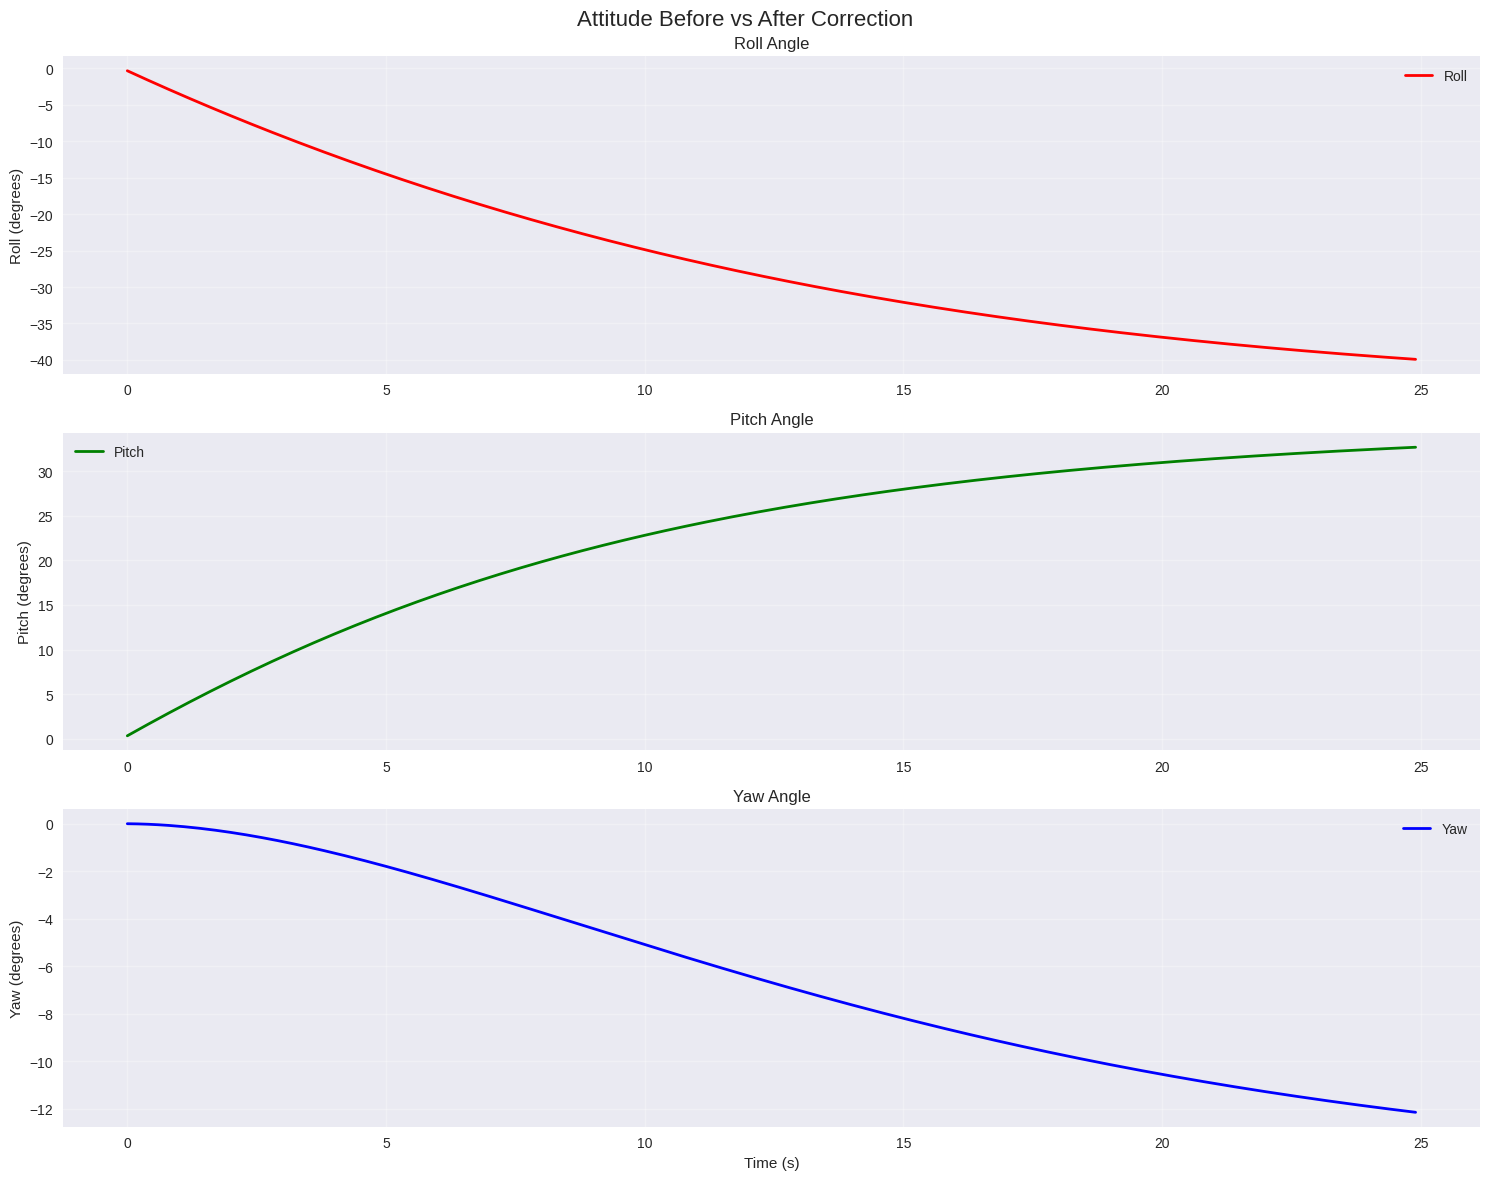


CORRECTION ANALYSIS
Initial attitude: Roll=-0.33°, Pitch=0.33°, Yaw=-0.00°

Final attitude:    Roll=-39.92°, Pitch=32.69°, Yaw=-12.16°



In [20]:
# Plot results - Before vs After Correction
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Attitude Before vs After Correction', fontsize=16)

# Plot Roll
axes[0].plot(time_array, euler[:, 0], 'r-', linewidth=2, label='Roll')
axes[0].set_ylabel('Roll (degrees)')
axes[0].set_title('Roll Angle')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot Pitch
axes[1].plot(time_array, euler[:, 1], 'g-', linewidth=2, label='Pitch')
axes[1].set_ylabel('Pitch (degrees)')
axes[1].set_title('Pitch Angle')
axes[1].grid(True, alpha=0.3)
axes[1].legend()


# Plot Yaw
axes[2].plot(time_array, euler[:, 2], 'b-', linewidth=2, label='Yaw')
axes[2].set_ylabel('Yaw (degrees)')
axes[2].set_xlabel('Time (s)')
axes[2].set_title('Yaw Angle')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()


# Print summary statistics
print("\n" + "="*60)
print("CORRECTION ANALYSIS")
print("="*60)
print(f"Initial attitude: Roll={euler[0,0]:.2f}°, Pitch={euler[0,1]:.2f}°, Yaw={euler[0,2]:.2f}°")
print()
print(f"Final attitude:    Roll={euler[-1,0]:.2f}°, Pitch={euler[-1,1]:.2f}°, Yaw={euler[-1,2]:.2f}°")
print()
